In [1]:
import os
os.environ['THEANO_FLAGS'] = 'floatX=float32,device=gpu0,nvcc.fastmath=True,optimizer_including=cudnn'

In [1]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Reshape
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D
from keras.utils import np_utils

Using Theano backend.
Using gpu device 0: GeForce GT 750M (CNMeM is enabled with initial size: 75.0% of memory, CuDNN 4007)


In [3]:
amps = np.load('data/28k/images.npy')
amps.shape

(28488, 32, 32)

In [32]:
n_bands = amps.shape[1]
n_time = amps.shape[2]
nb_filters = 32
nb_row = 3
nb_col = 3
pool_size = (2,2)
nb_encode = 128
# dropout = 0.2
activation = 'relu'
border_mode = 'same'

model = Sequential()
model.add(Reshape((1, n_bands, n_time), input_shape=(n_bands, n_time)))
model.add(Convolution2D(nb_filters/8, nb_row, nb_col, activation=activation, border_mode=border_mode))
model.add(Convolution2D(nb_filters/8, nb_row, nb_col, activation=activation, border_mode=border_mode))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Convolution2D(nb_filters/4, nb_row, nb_col, activation=activation, border_mode=border_mode))
model.add(Convolution2D(nb_filters/4, nb_row, nb_col, activation=activation, border_mode=border_mode))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Convolution2D(nb_filters/2, nb_row, nb_col, activation=activation, border_mode=border_mode))
model.add(Convolution2D(nb_filters/2, nb_row, nb_col, activation=activation, border_mode=border_mode))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Convolution2D(nb_filters, nb_row, nb_col, activation=activation, border_mode=border_mode))
model.add(Convolution2D(nb_filters, nb_row, nb_col, activation=activation, border_mode=border_mode))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Flatten(name='encoded'))
model.add(Reshape((nb_filters, 2, 2)))  # todo: auto
model.add(UpSampling2D(size=pool_size))
model.add(Convolution2D(nb_filters, nb_row, nb_col, activation=activation, border_mode=border_mode))
model.add(Convolution2D(nb_filters, nb_row, nb_col, activation=activation, border_mode=border_mode))
model.add(UpSampling2D(size=pool_size))
model.add(Convolution2D(nb_filters/2, nb_row, nb_col, activation=activation, border_mode=border_mode))
model.add(Convolution2D(nb_filters/2, nb_row, nb_col, activation=activation, border_mode=border_mode))
model.add(UpSampling2D(size=pool_size))
model.add(Convolution2D(nb_filters/4, nb_row, nb_col, activation=activation, border_mode=border_mode))
model.add(Convolution2D(nb_filters/4, nb_row, nb_col, activation=activation, border_mode=border_mode))
model.add(UpSampling2D(size=pool_size))
model.add(Convolution2D(nb_filters/8, nb_row, nb_col, activation=activation, border_mode=border_mode))
model.add(Convolution2D(1, nb_row, nb_col, activation=activation, border_mode=border_mode))
model.add(Reshape((n_bands, n_time)))
print model.summary()

--------------------------------------------------------------------------------
Initial input shape: (None, 32, 32)
--------------------------------------------------------------------------------
Layer (name)                  Output Shape                  Param #             
--------------------------------------------------------------------------------
Reshape (reshape)             (None, 1, 32, 32)             0                   
Convolution2D (convolution2d) (None, 4, 32, 32)             40                  
Convolution2D (convolution2d) (None, 4, 32, 32)             148                 
MaxPooling2D (maxpooling2d)   (None, 4, 16, 16)             0                   
Convolution2D (convolution2d) (None, 8, 16, 16)             296                 
Convolution2D (convolution2d) (None, 8, 16, 16)             584                 
MaxPooling2D (maxpooling2d)   (None, 8, 8, 8)               0                   
Convolution2D (convolution2d) (None, 16, 8, 8)              1168         

In [33]:
%time model.compile(loss='mse', optimizer='rmsprop')

CPU times: user 1min 5s, sys: 1.63 s, total: 1min 7s
Wall time: 1min 46s


In [ ]:
model.fit(amps, amps, verbose=2, nb_epoch=1, batch_size=64)

In [10]:
from keras import backend as K
get_encoding = K.function([model.layers[0].input], 
                          [model.layers[11].get_output(train=False)])

In [11]:
encoding = get_encoding([batch])[0]

In [12]:
from scipy.spatial.distance import pdist, squareform
distances_vector = pdist(encoding, 'cosine')
distances_matrix = squareform(distances_vector)

0.0104745079818
343053
273 984


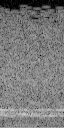

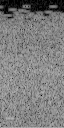

In [17]:
best = sorted(distances_vector)[np.random.randint(0,1000)]
print best
match = (distances_matrix == best).argmax()
print match
a = match / len(encoding)
b = match % len(encoding)
print a, b
showarray(batch[a]*255)
showarray(batch[b]*255)

In [18]:
predicted = model.predict(batch)

In [19]:
predicted.shape

(1253, 128, 64)

In [ ]:
for i in range(10):
    showarray(batch[i] * 255)
    showarray(predicted[i] * 255)